In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline 
from __future__ import division

In [2]:
#Utilities imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#Specific usage imports
from openfisca_core import rates
from openfisca_core.tools import get_trace_tool_link
import openfisca_france

In [4]:
pip_show = !pip show openfisca-france

In [5]:

version = pip_show[3]
name = pip_show[2][6:]
source = "Souce : " + name + "\n"+ version
print source

Souce : OpenFisca-France
Version: 4.1.11


Initialize the tax and benefit system of France

In [6]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

Create a scenario

In [7]:
ax_variable_max = 60000
count = 1000
def make_single_with_child_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count):
    enfant = [dict(
        age = 12,
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            ),
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = 4,
            depcom = 13012,
            ),
        )
    return scenario

def make_couple_with_child_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count):
    enfant = [dict(
        age = 12,
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = ax_variable_min,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = 1
            ),
        parent2 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = 1
            ),
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = 4,
            depcom = 13012,
            ),
        )
    return scenario


In [8]:
sim_dict_2016 = dict(); sim_dict_2016[0] = dict(); sim_dict_2016[1] = dict()
for couple in [True, False]:
    if couple == True:
        sim_dict_2016[0]
        for children in range(0,4):
            simulation = make_single_with_child_scenario(nombre_enfants= children,
                                                         year = 2016).new_simulation(trace = True)
            sim_dict_2016[0][children] = simulation
    if couple == False:
        sim_dict_2016[1]
        for children in range(0,4):
            simulation = make_couple_with_child_scenario(nombre_enfants= children,
                                                         year = 2016).new_simulation()
            sim_dict_2016[1][children] = simulation
            
sim_dict_2015 = dict(); sim_dict_2015[0] = dict(); sim_dict_2015[1] = dict()
for couple in [True, False]:
    if couple == True:
        sim_dict_2015[0]
        for children in range(0,4):
            simulation = make_single_with_child_scenario(nombre_enfants= children,
                                                         year = 2015).new_simulation()
            sim_dict_2015[0][children] = simulation
    if couple == False:
        sim_dict_2015[1]
        for children in range(0,4):
            simulation = make_couple_with_child_scenario(nombre_enfants= children,
                                                         year = 2015).new_simulation()
            sim_dict_2015[1][children] = simulation

In [9]:
from numpy import maximum as max_
def rsa_socle(simulation= None):
    period = simulation.period
    rsa_socle = simulation.calculate_add('rsa_socle', period)
    rsa_revenu_activite = simulation.calculate_add('rsa_revenu_activite', period)
    rsa_forfait_logement = simulation.calculate_add('rsa_forfait_logement', period)
    rsa_base_ressources = simulation.calculate_add('rsa_base_ressources', period)
    P = simulation.legislation_at(period.start).minim.rmi

    rsa_socle = max_(rsa_socle - rsa_forfait_logement - rsa_base_ressources, 0)

    return period, base_normalise * (base_normalise >= P.rsa_nv)


from numpy import maximum as max_
def rsa_activite(simulation= None):
    rsa_socle = rsa_socle(simulation)
    rsa_revenu_activite = simulation.calculate_add('rsa_revenu_activite', period)
    rsa_activite =   (rsa_socle - 0.62 * rsa_revenu_activite)
    return period, rsa_activite


## 2016

In [10]:
simulation = sim_dict_2015[0][3]
simulation.calculate("aides_logement")[0]/12 #pourquoi si bas !

289.06009928385419

In [11]:
simulation.period

Period((u'year', Instant((2015, 1, 1)), 1))

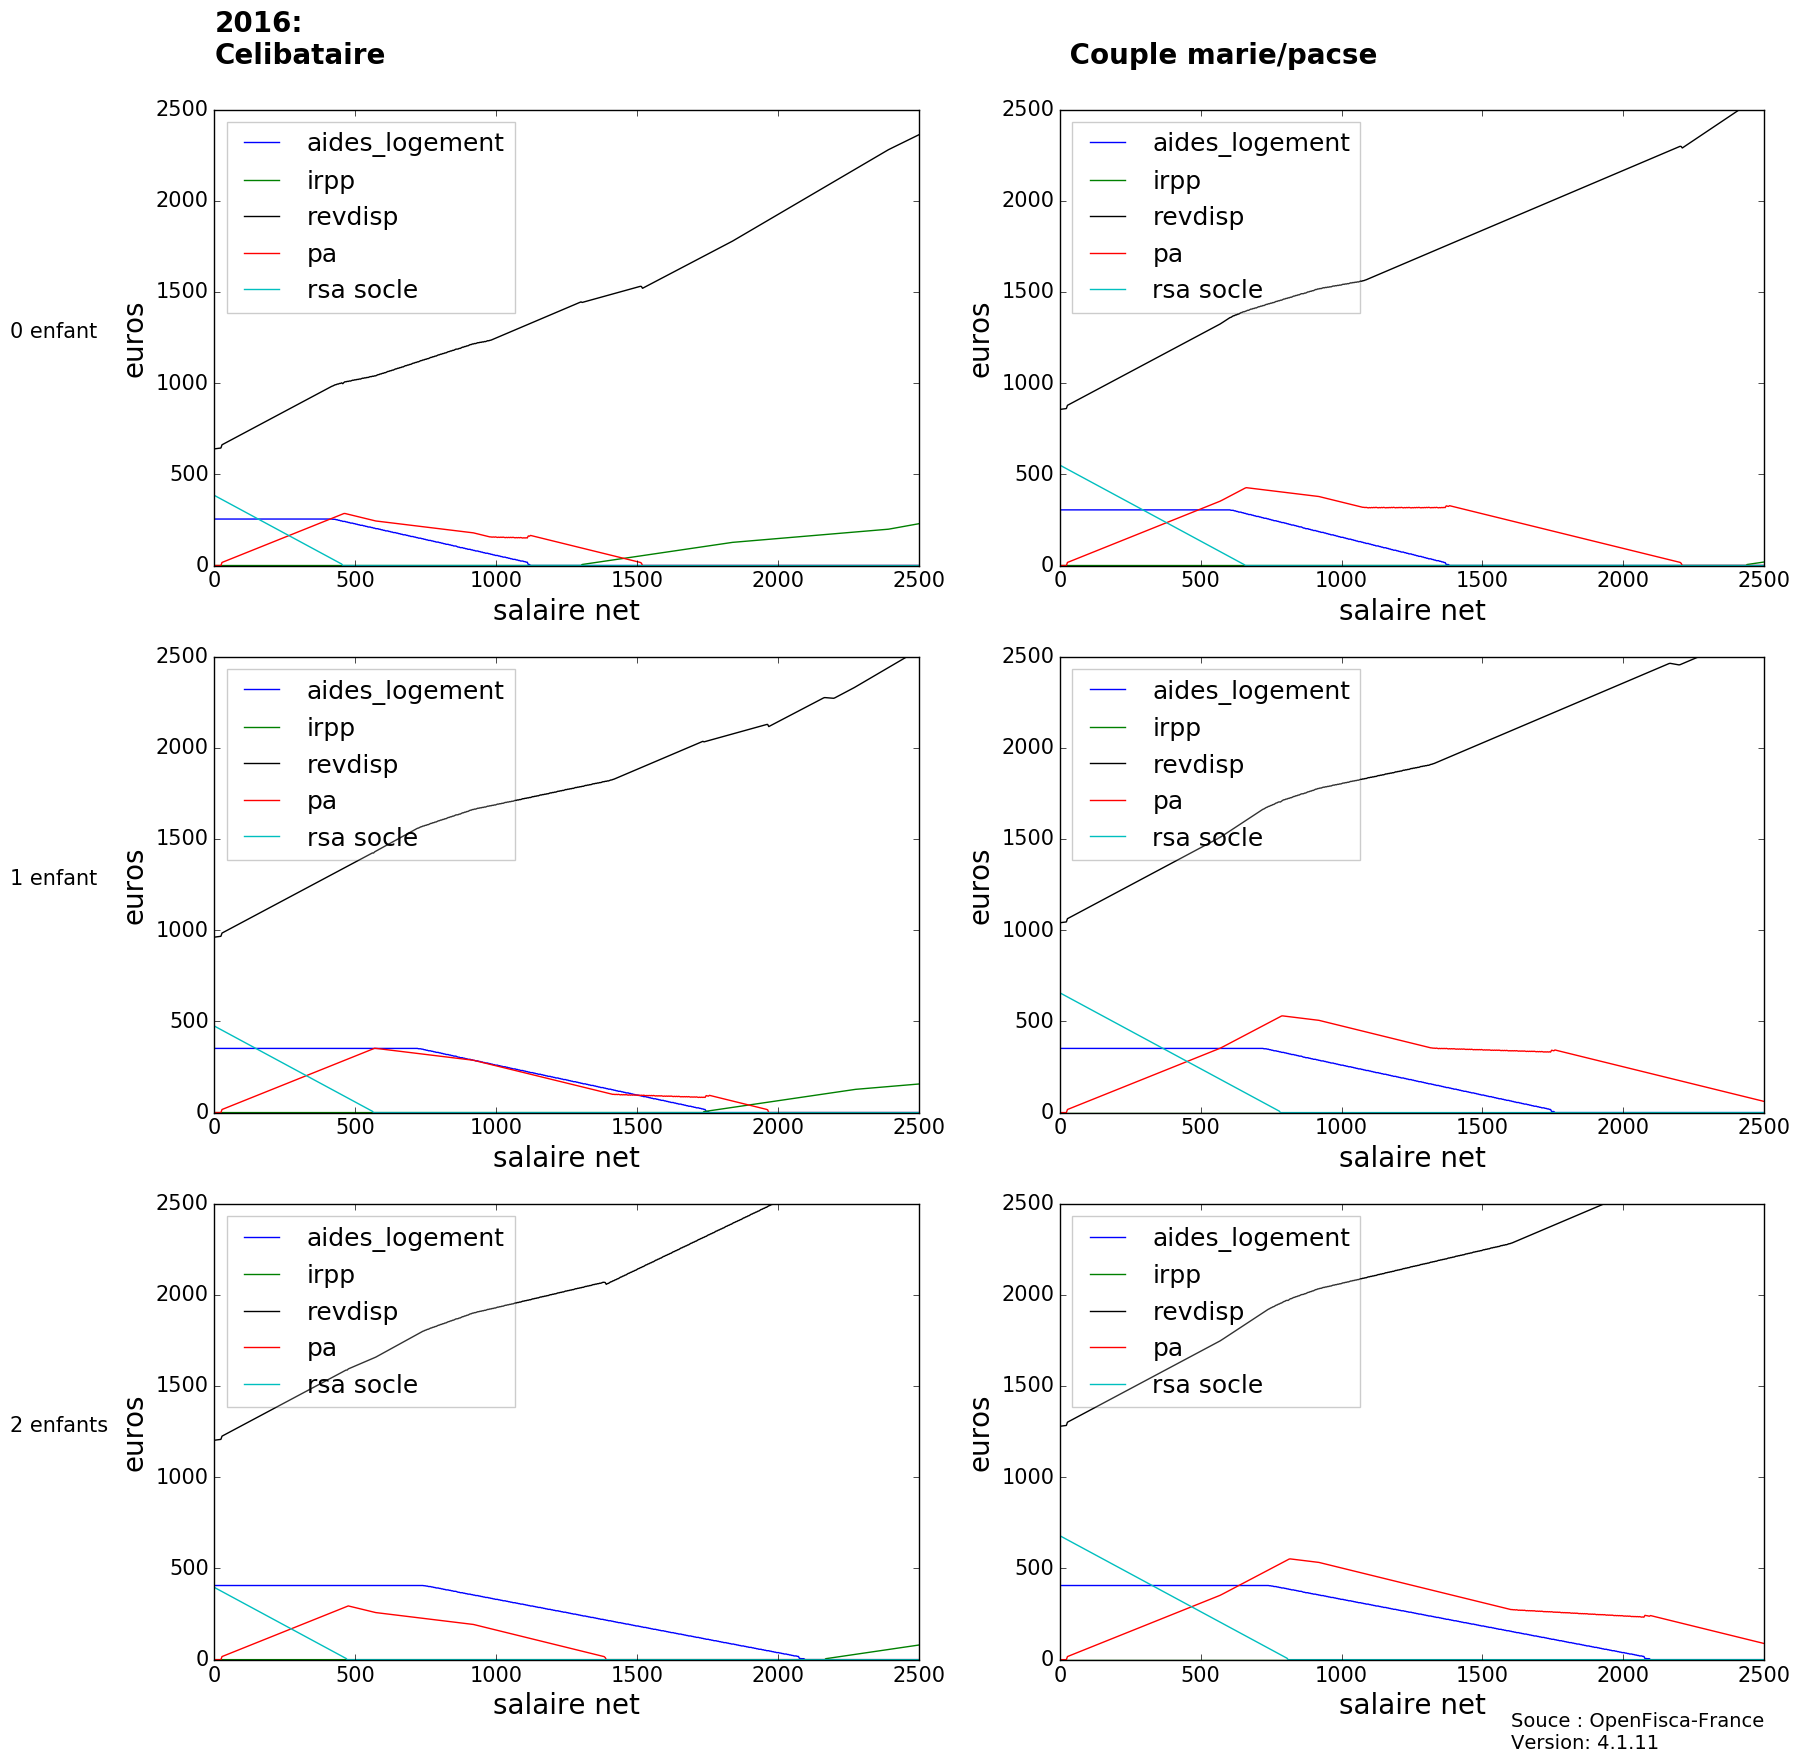

In [86]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))

for col in range(2):
    for raw in range(3):
        simulation = sim_dict_2016[col][raw]
        for var in ["aides_logement", "irpp"]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = var
                    )
        for var in ["revdisp"]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = var, color ='k'
                    )
        for var in ["ppa"]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = "pa"
                    )
        for var in ["rsa",]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = "rsa socle"
                    )
        



  
        ax[raw,col].set_xlim(0,2500)
        ax[raw,col].set_ylim(0,2500)
        legend = ax[raw,col].legend(loc = 2, fontsize = 18); legend.get_frame().set_alpha(0.2)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize); 
        ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"2016:\nCelibataire"*(col==0)+u"\n Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
plt.text(1600, -490, s = source, fontsize=14)

## 2015

In [14]:
revenu = simulation.calculate_add("rsa_revenu_activite")
pre_rsa_socle = (simulation.calculate_add("rsa_socle") - simulation.calculate_add("rsa_revenu_activite"))
rsa_socle = ((pre_rsa_socle>0)*(pre_rsa_socle))/12
rsa_activite = (rsa_socle - simulation.calculate_add("rsa")/12)

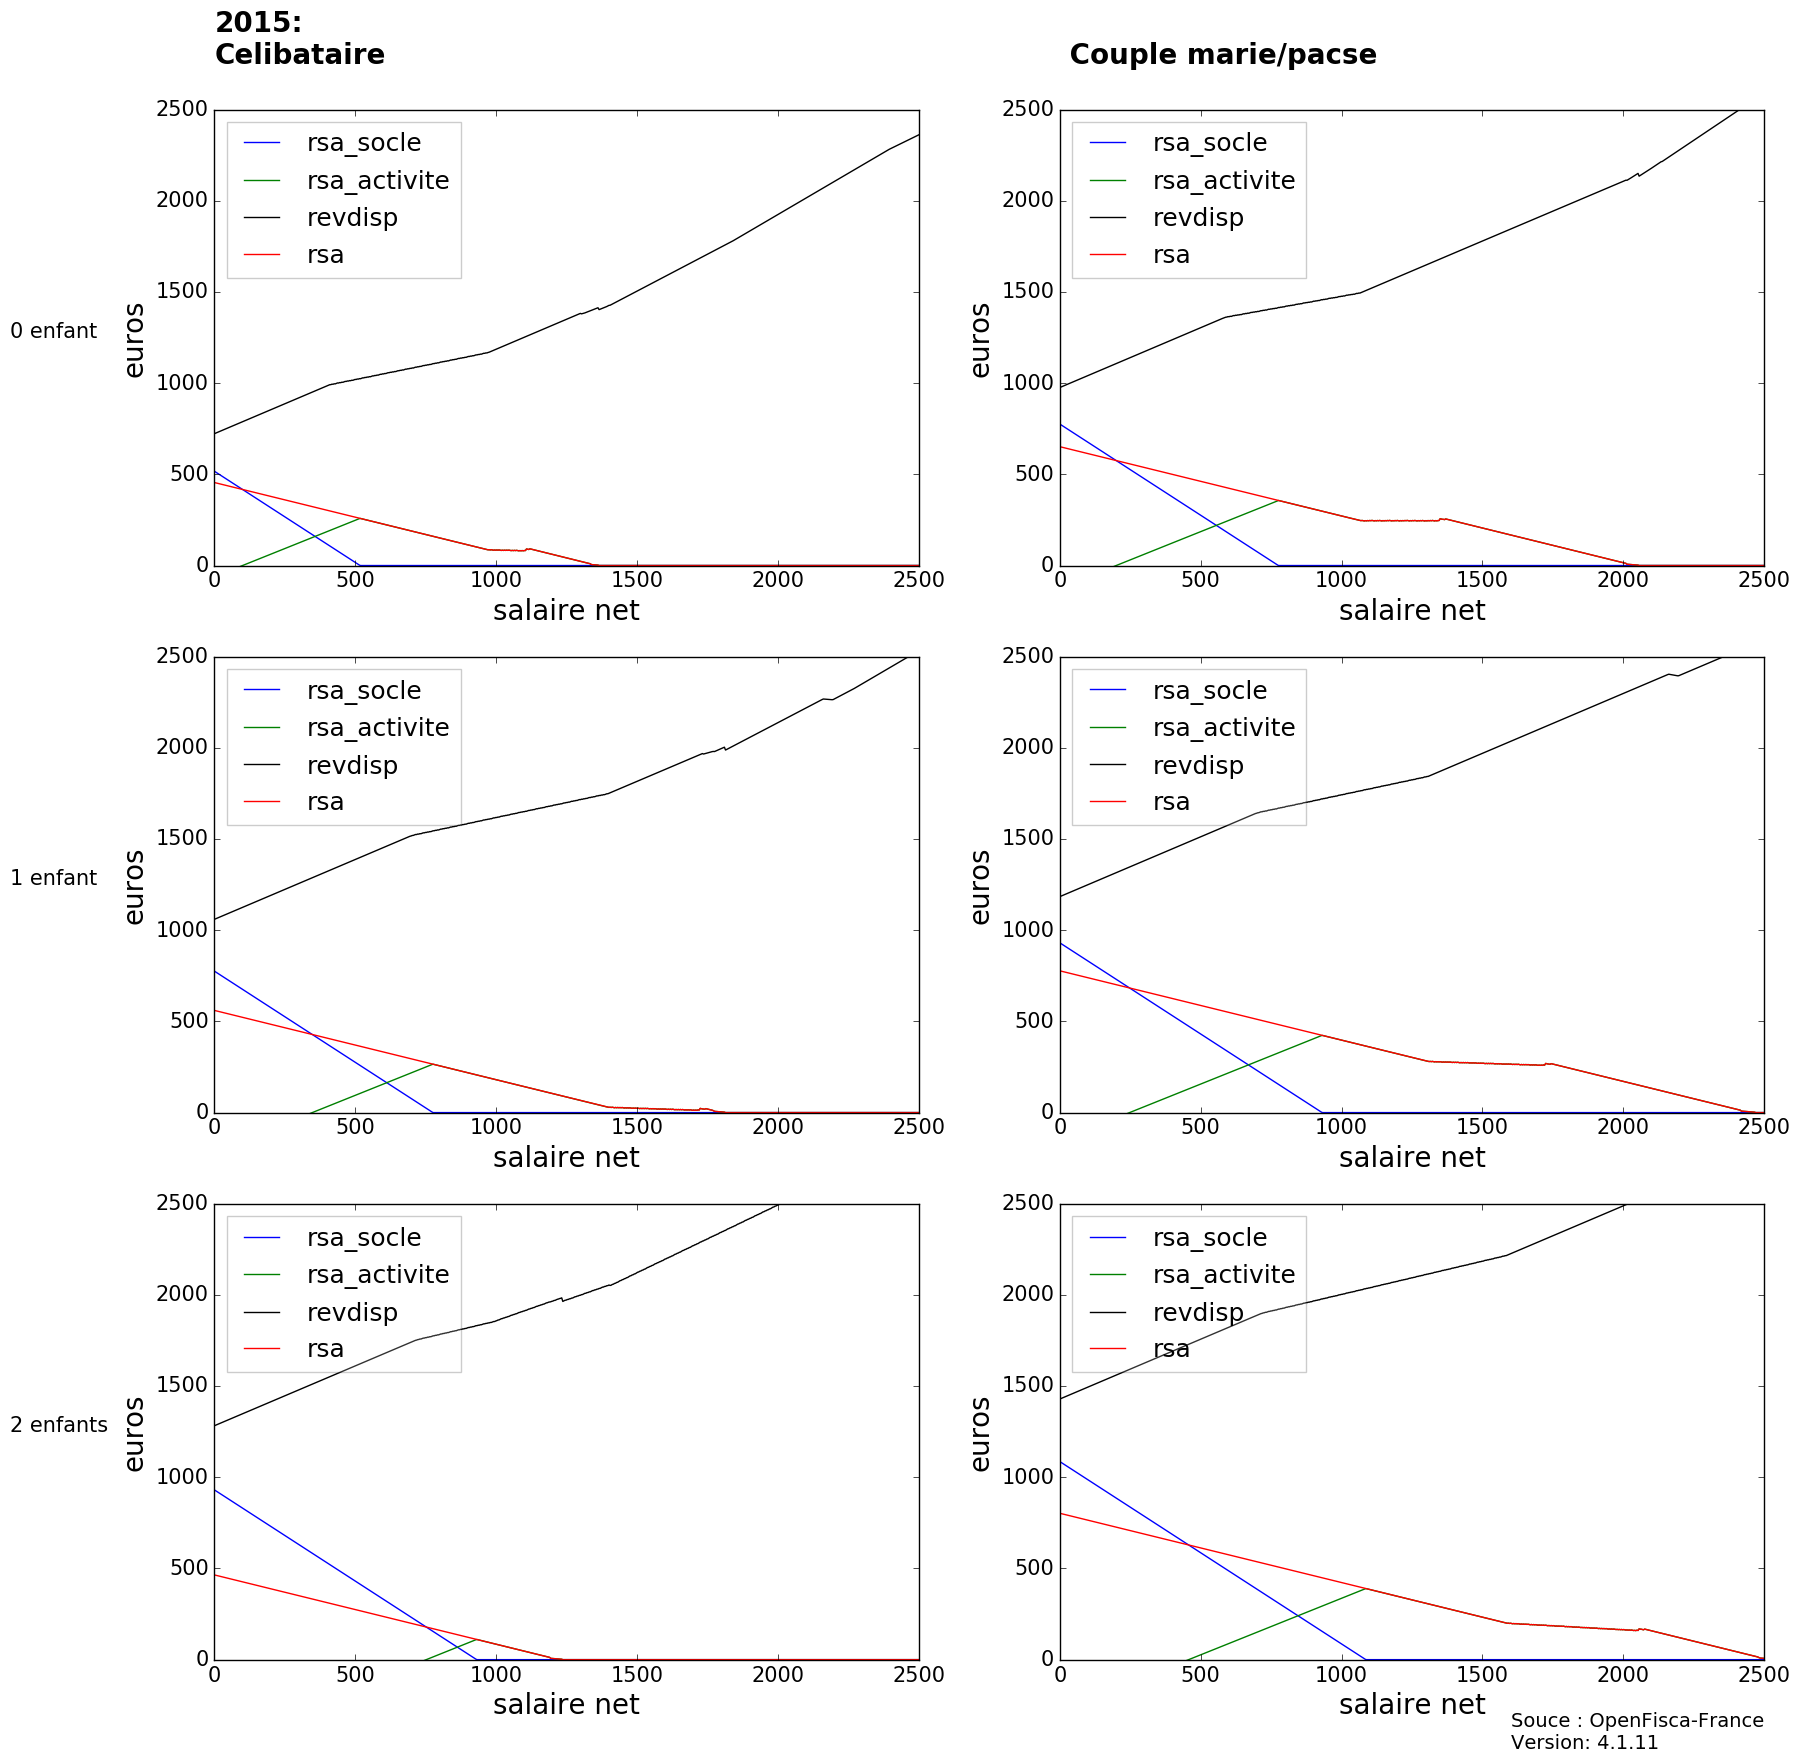

In [89]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))

for col in range(2):
    for raw in range(3):
        simulation = sim_dict_2015[col][raw]

        pre_rsa_socle = (simulation.calculate_add("rsa_socle") - simulation.calculate_add("rsa_revenu_activite"))
        rsa_socle = ((pre_rsa_socle>0)*(pre_rsa_socle))/12
        
        rsa_activite = (simulation.calculate_add("rsa")/12)- rsa_socle
        #(simulation.calculate_add("rsa_socle") - simulation.calculate_add("rsa"))/12

        ax[raw,col].plot(
                 (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                 rsa_socle,
                label = "rsa_socle"
                )

        ax[raw,col].plot(
                 (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                 rsa_activite,
                label = "rsa_activite"
                )
        for var in ["revdisp"]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = var, color ='k'
                    )
        for var in [ "rsa"]:
            ax[raw,col].plot(
                     (simulation.calculate_add("salaire_net")/12)[::raw+col+1],
                     np.abs(simulation.calculate_add(var)/12), label = var,
                    )

  
        ax[raw,col].set_xlim(0,2500)
        ax[raw,col].set_ylim(0,2500)
        legend = ax[raw,col].legend(loc = 2, fontsize=18); legend.get_frame().set_alpha(0.2)
        ax[raw,col].set_ylabel('euros', fontsize=fontsize); ax[raw,col].set_xlabel('salaire net', fontsize=fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"2015:\nCelibataire"*(col==0)+u"\n Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
plt.text(1600, -490, s = source, fontsize=14)

## 2015 vs. 2016 (bon graph)

merci
il y a des pbs pour 2015: RSA socle et activité sont faux. Le RSA socle est : B-R, le RSA total est: B-0.38R. Donc le RSA activité est la différence des deux, soit 0.62 R, tant que le RSA socle est positif; quand il s'annule à R=B, le RSA activité devient B-0.38R.

Le pb se répercute sur le graph differentiel.
Peux tu aussi faire un graph avec simplement le revdispo 2015, revdispo 2016, aide emploi 2015 (RSA activité+PPE) et aide emploi 2016 (PA) ? comme ça on voit bien là où ça domine le systeme précédent

merci!!!

#### Aide à l'emploi

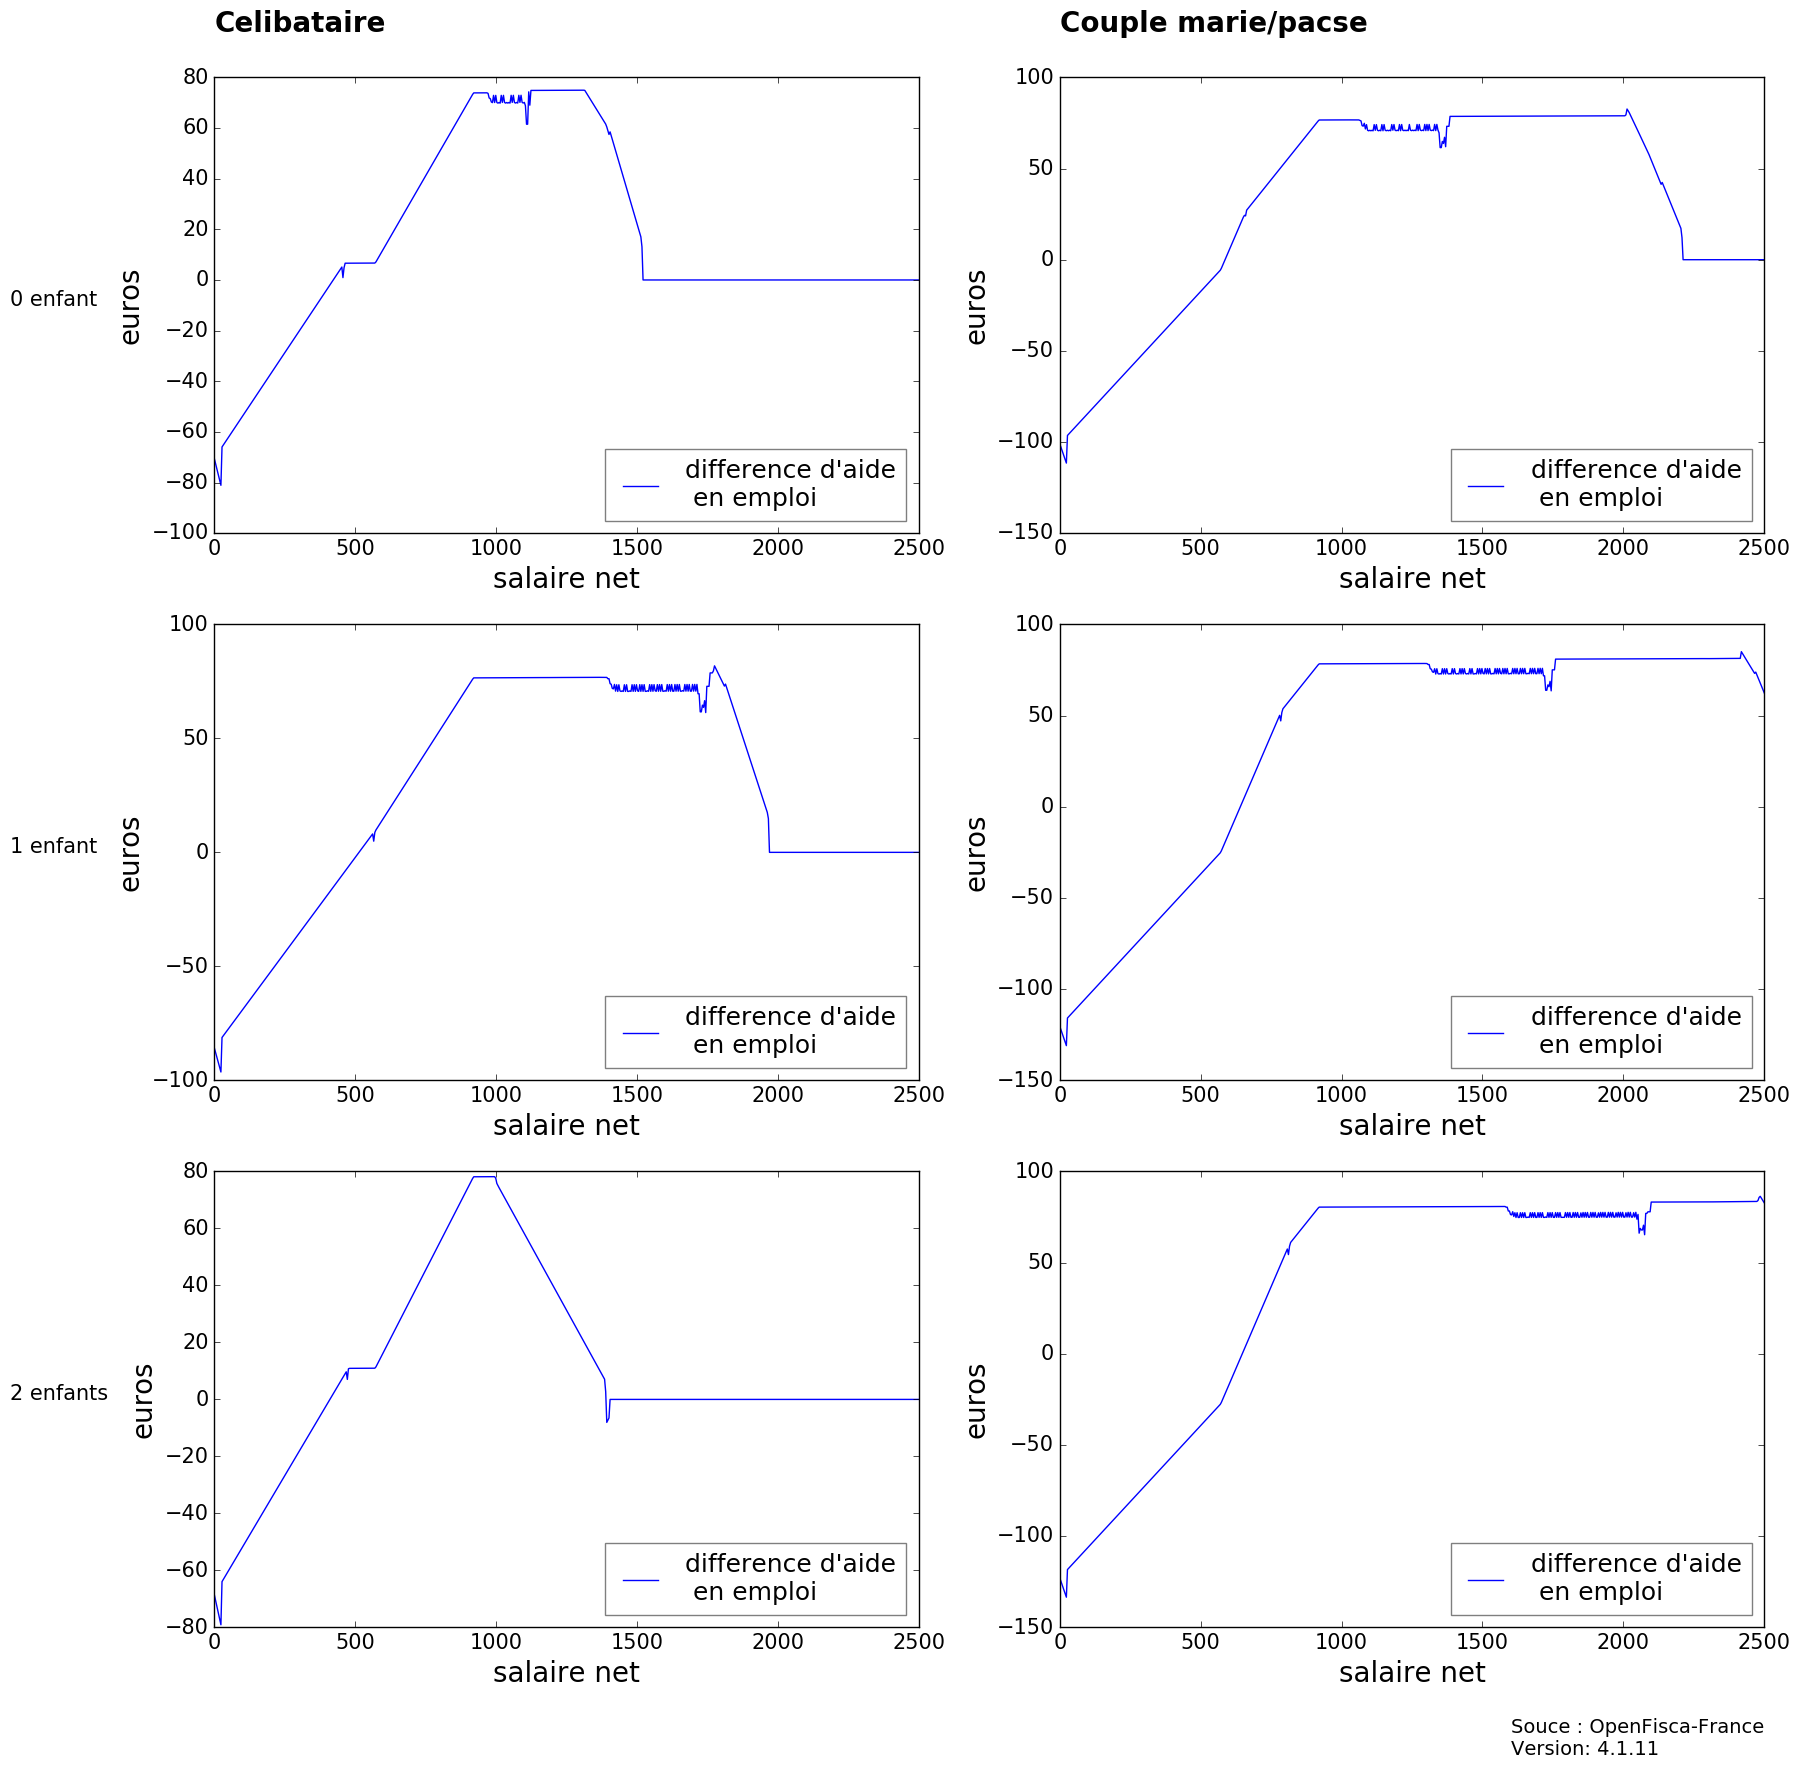

In [63]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))

for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        aide_emploi_2015 = (simulation_2015.calculate_add("ppe") + simulation_2015.calculate_add("rsa"))/12
        aide_emploi_2016 = (simulation_2016.calculate_add("ppa") + simulation_2016.calculate_add("rsa"))/12
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2016 - aide_emploi_2015,
            label = "difference d'aide\n en emploi"
                )
        
    
        
        
        ax[raw,col].set_xlim(0,2500)
        #ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 4, fontsize = 18); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize); ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
plt.text(1600, -220, s = source, fontsize=14)

#### Diff de revdisp

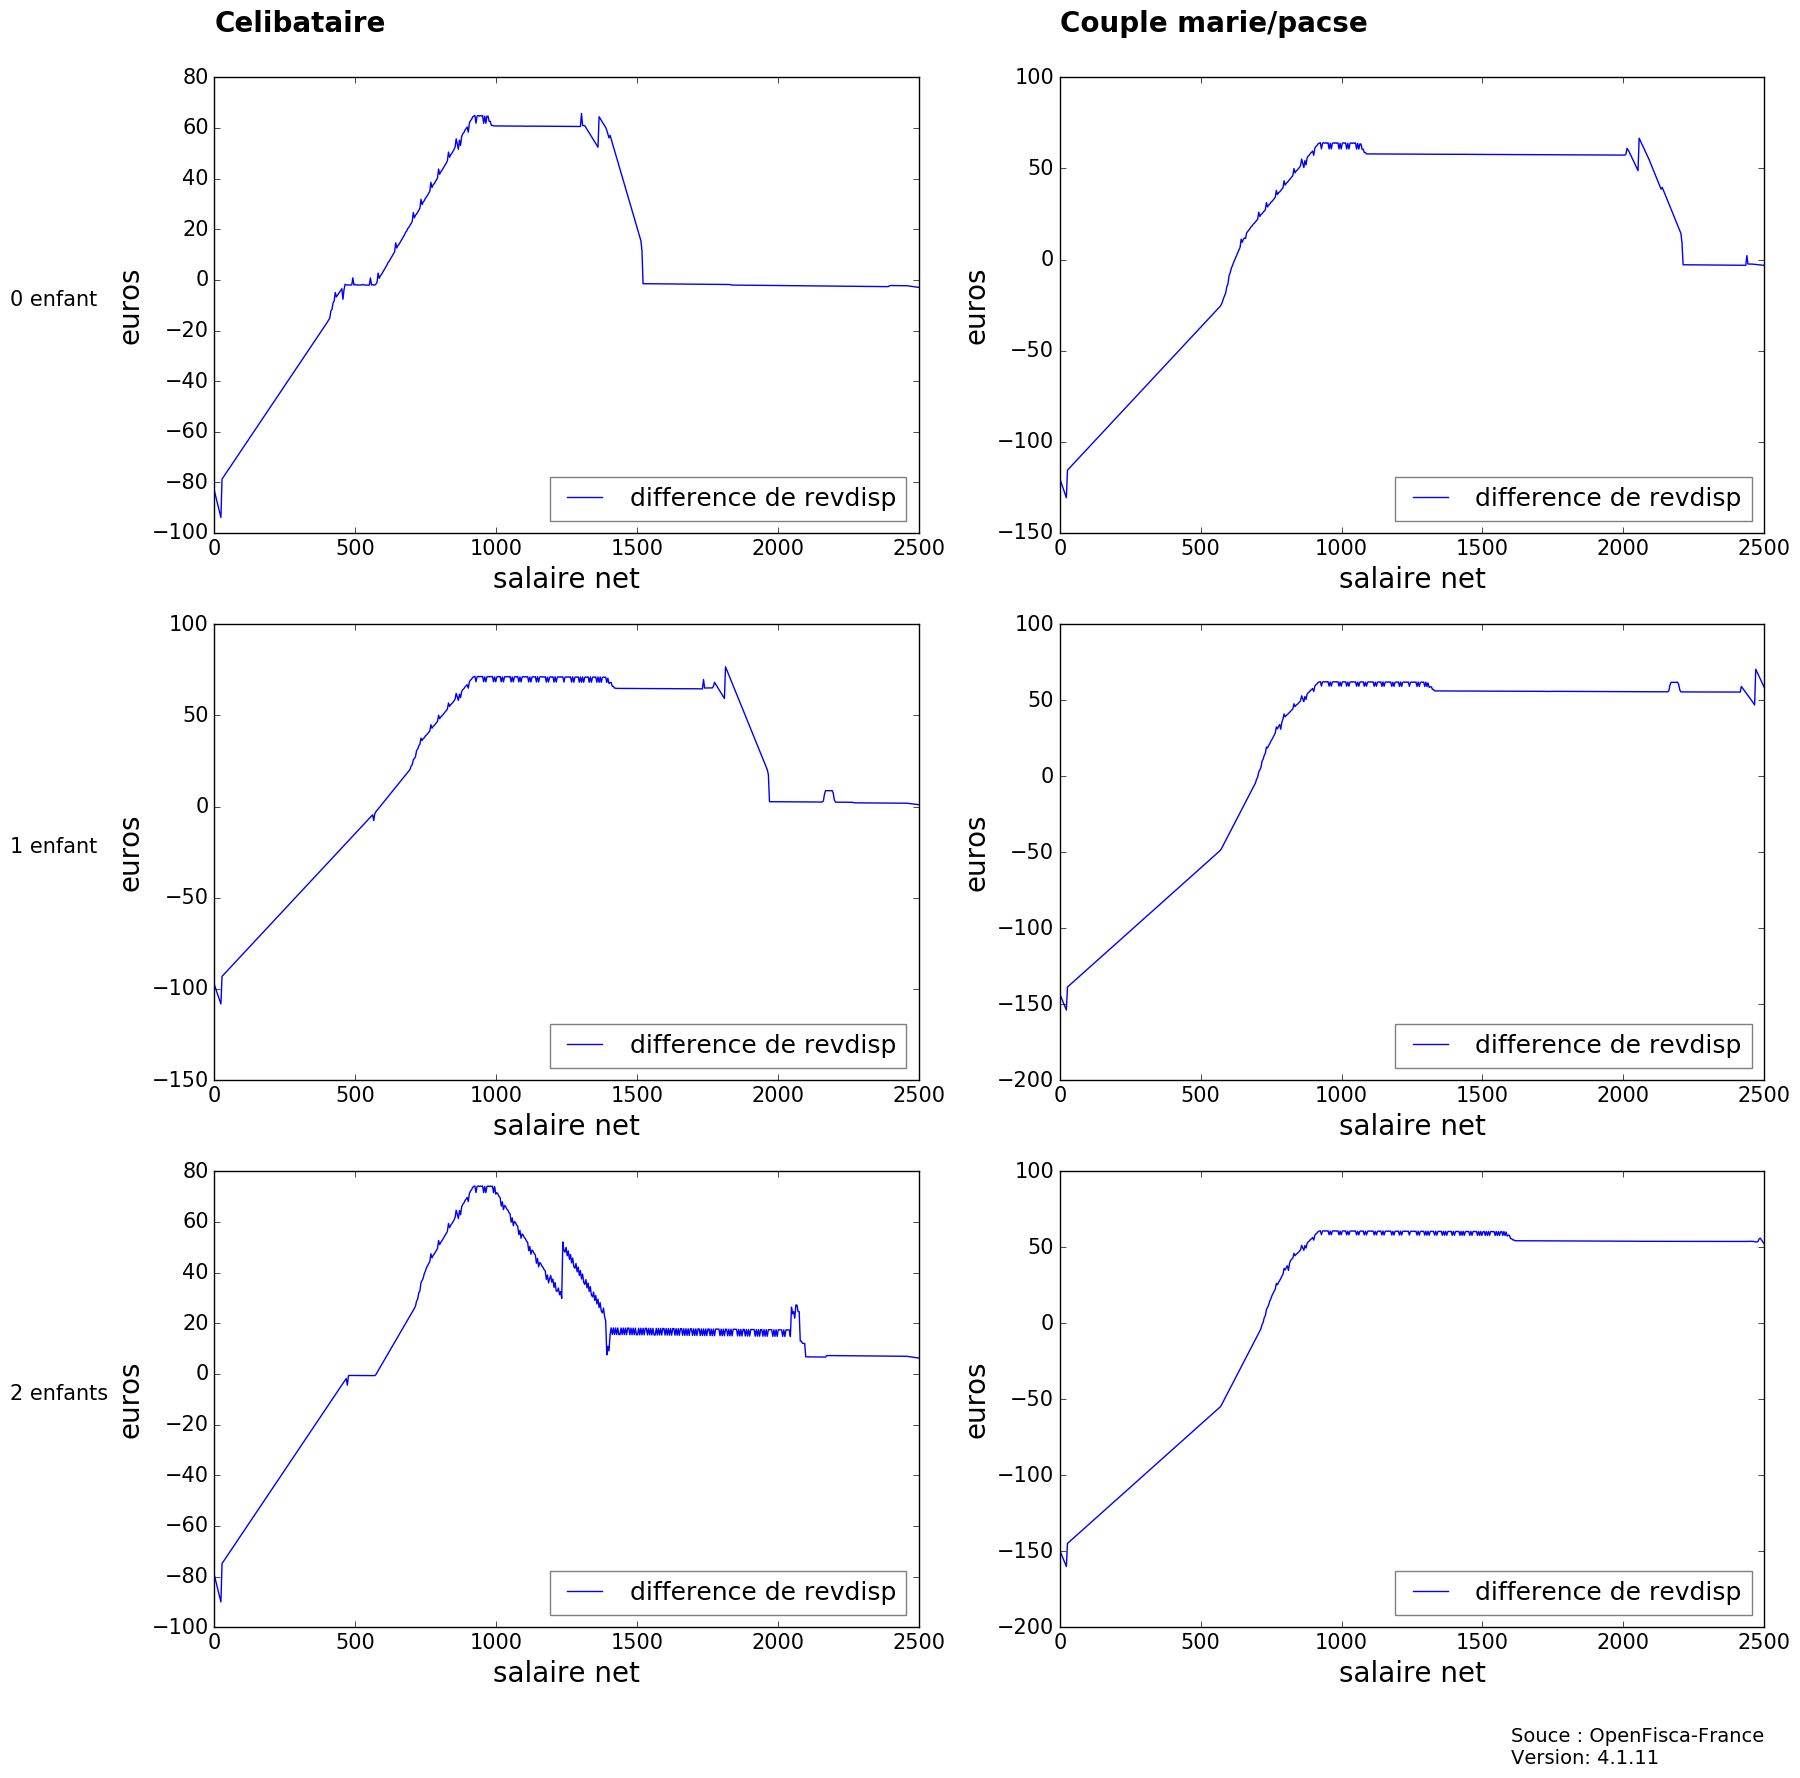

In [61]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))
fontsize = 20
for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        revdisp_2015 = simulation_2015.calculate_add("revdisp")/12
        revdisp_2016 = simulation_2016.calculate_add("revdisp")/12
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2016 - revdisp_2015,
            label = 'difference de revdisp'
                )
        
        
        
        ax[raw,col].set_xlim(0,2500)
        #ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 4, fontsize = 18); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize); ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
    

            
plt.text(1600, -290, s = source, fontsize=14)

##### Avec taux marginaux effectif

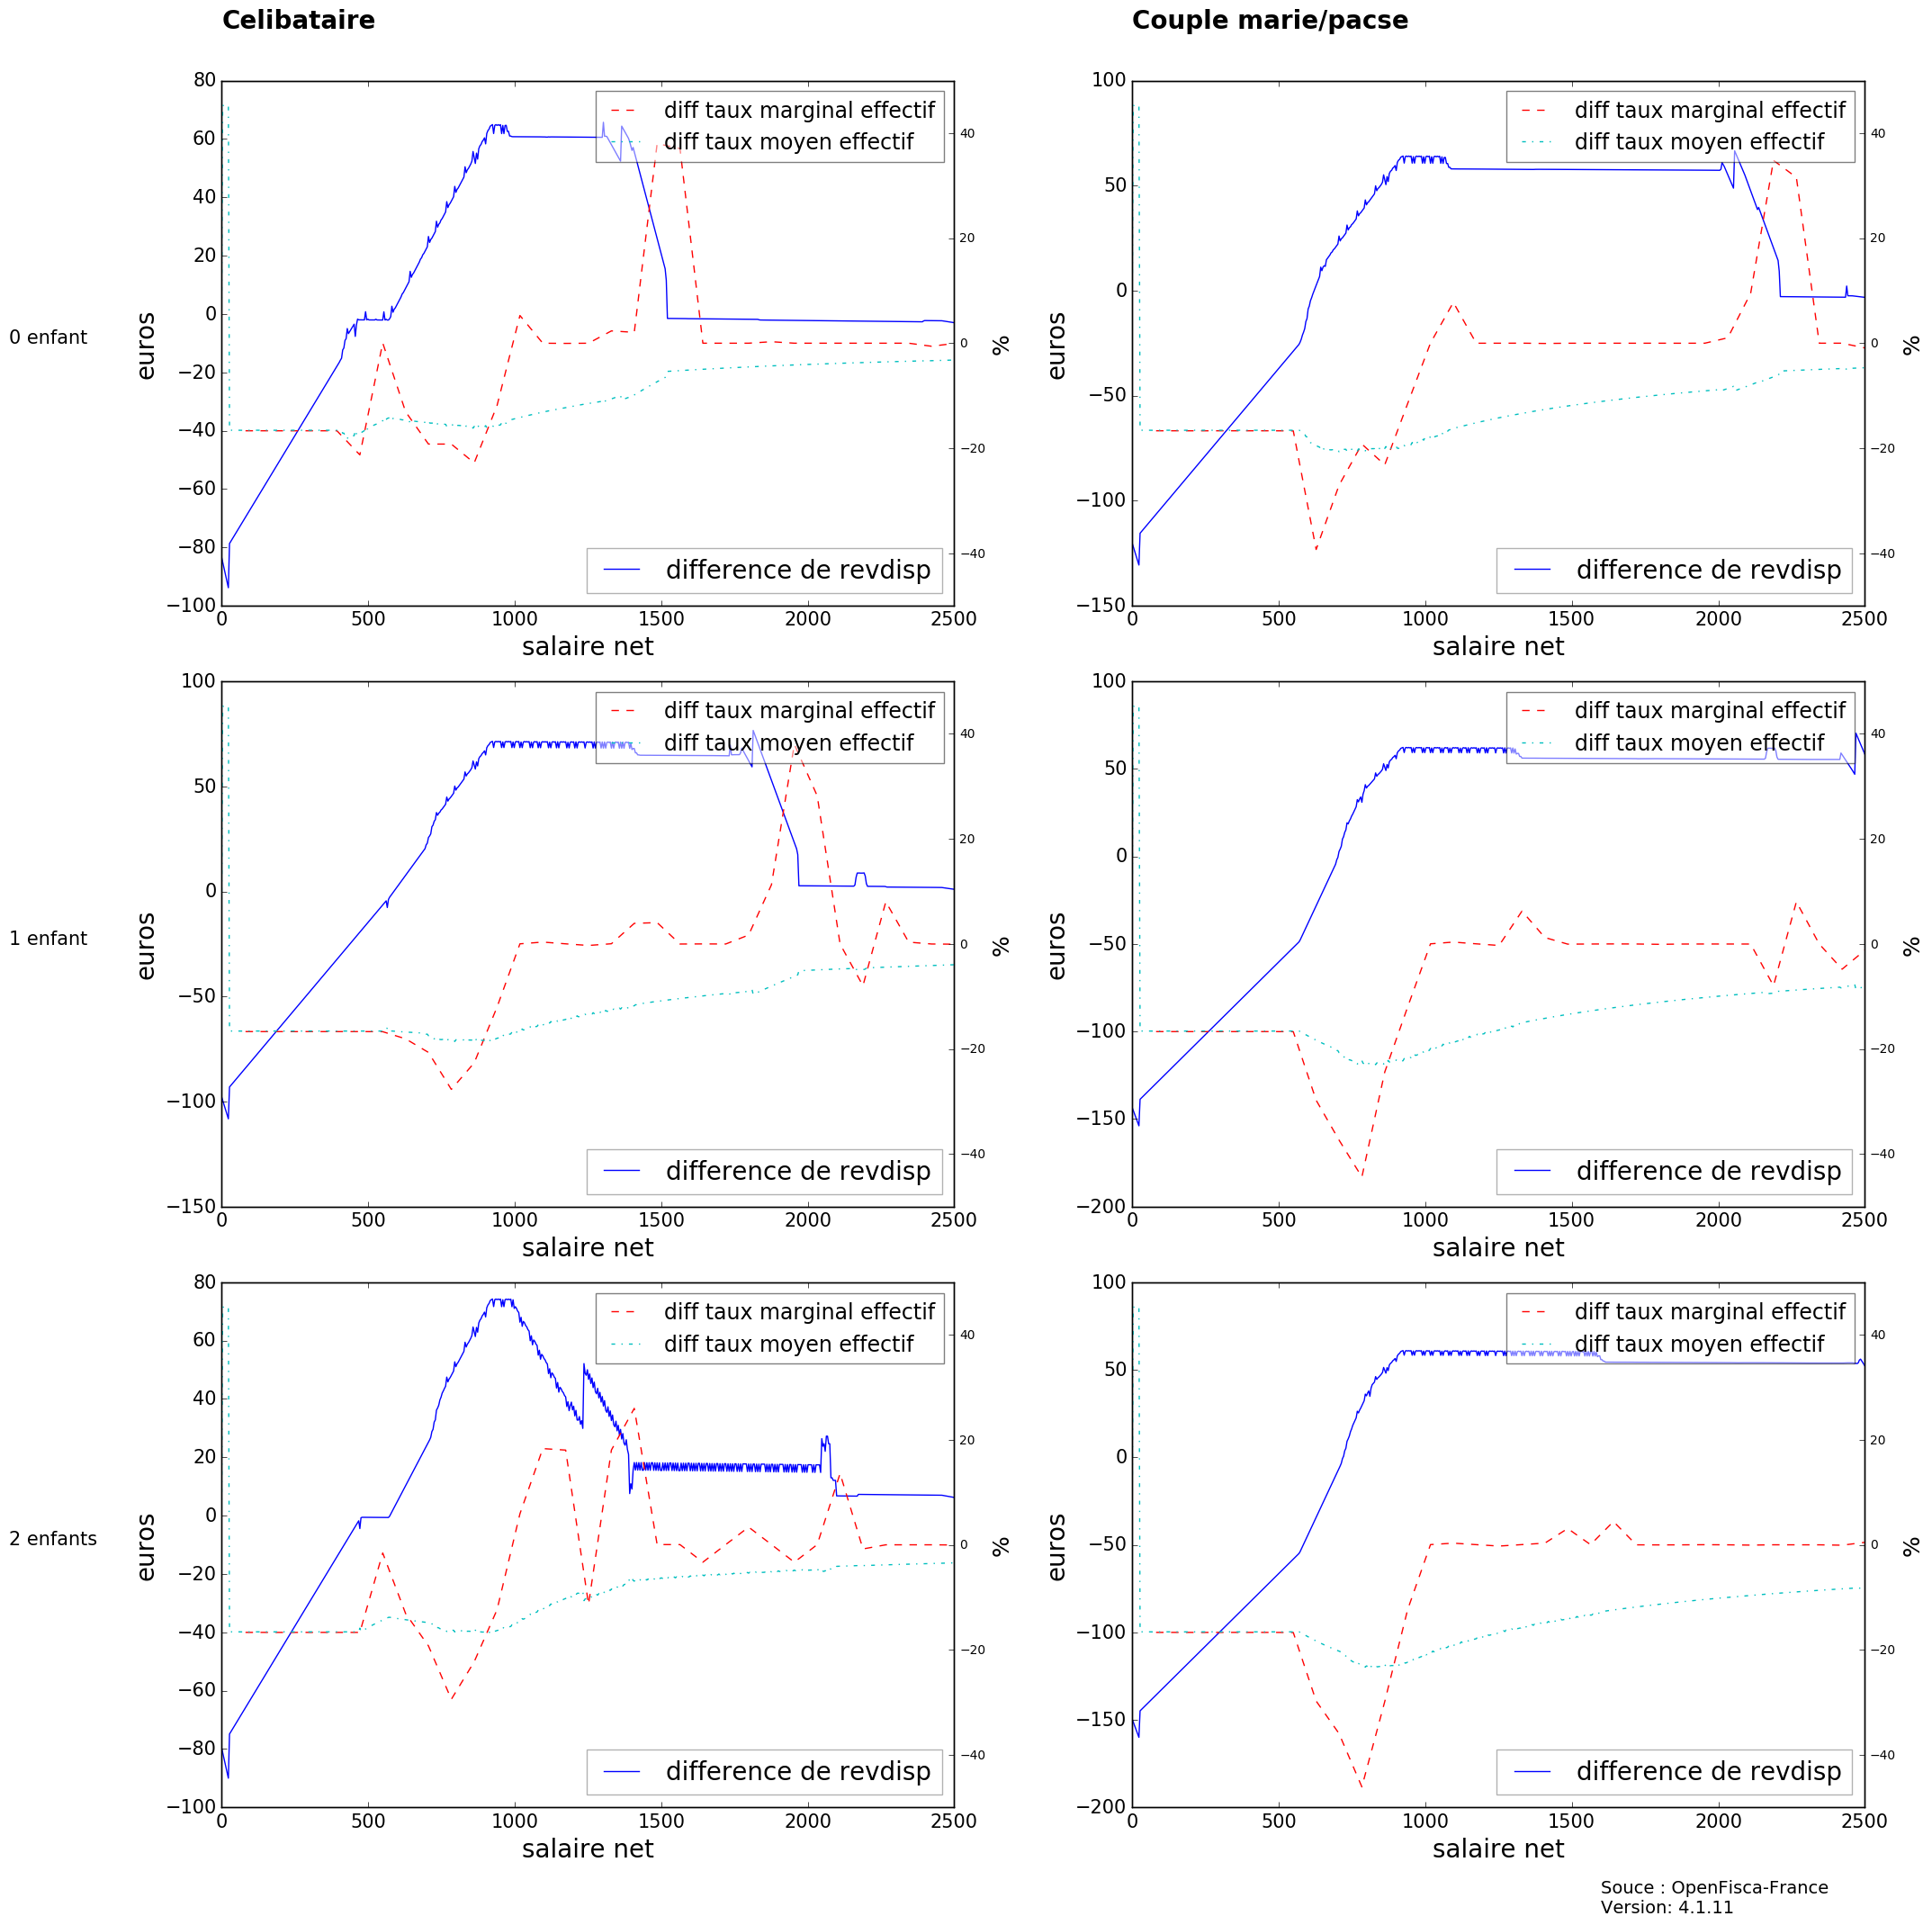

In [110]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))
fontsize = 20
for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        revdisp_2015 = simulation_2015.calculate_add("revdisp")/12
        revdisp_2016 = simulation_2016.calculate_add("revdisp")/12
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2016 - revdisp_2015,
            label = 'difference de revdisp'
                )
        
        # Tax rate
         ## Marginal Tax rate
        ax2 = ax[raw,col].twinx()
        smooth = 20 # need to be >= 2
        ax2.plot(simulation_2015.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth]/12,
                (
                (rates.marginal_rate(simulation_2016.calculate_add("revdisp")[::smooth],
                simulation_2016.calculate("salaire_net")[::raw+1+col][::smooth]))
                -
                (rates.marginal_rate(simulation_2015.calculate_add("revdisp")[::smooth],
                simulation_2015.calculate("salaire_net")[::raw+1+col][::smooth]))
                
                
            
                )*100,
                '--r',
                label = "diff taux marginal effectif",
            )
         ## Average Tax rate
        ax2.plot(simulation_2015.calculate_add("salaire_net")[::raw+1+col]/12,
                (
                (rates.average_rate(simulation_2016.calculate_add("revdisp")
                                    -simulation_2016.calculate_add("revdisp")[0],
                simulation_2015.calculate("salaire_net")[::raw+1+col]))
                -  (rates.average_rate(simulation_2015.calculate_add("revdisp")
                                    -simulation_2015.calculate_add("revdisp")[0],
                simulation_2015.calculate("salaire_net")[::raw+1+col]))
                )*100,
                 "c-.",
                 label = "diff taux moyen effectif",
            )
        legend = ax2.legend(loc = 1, fontsize=17); legend.get_frame().set_alpha(0.5)
        ax2.set_ylabel('%', fontsize = 18)
        ax2.set_ylim(-50,50)        
        
        ax[raw,col].set_xlim(0,2500)
        #ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 4, fontsize = 20); legend.get_frame().set_alpha(0.3)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize); ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
    

plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)       
plt.text(1600, -70, s = source, fontsize=14)

### Les deux à la fois

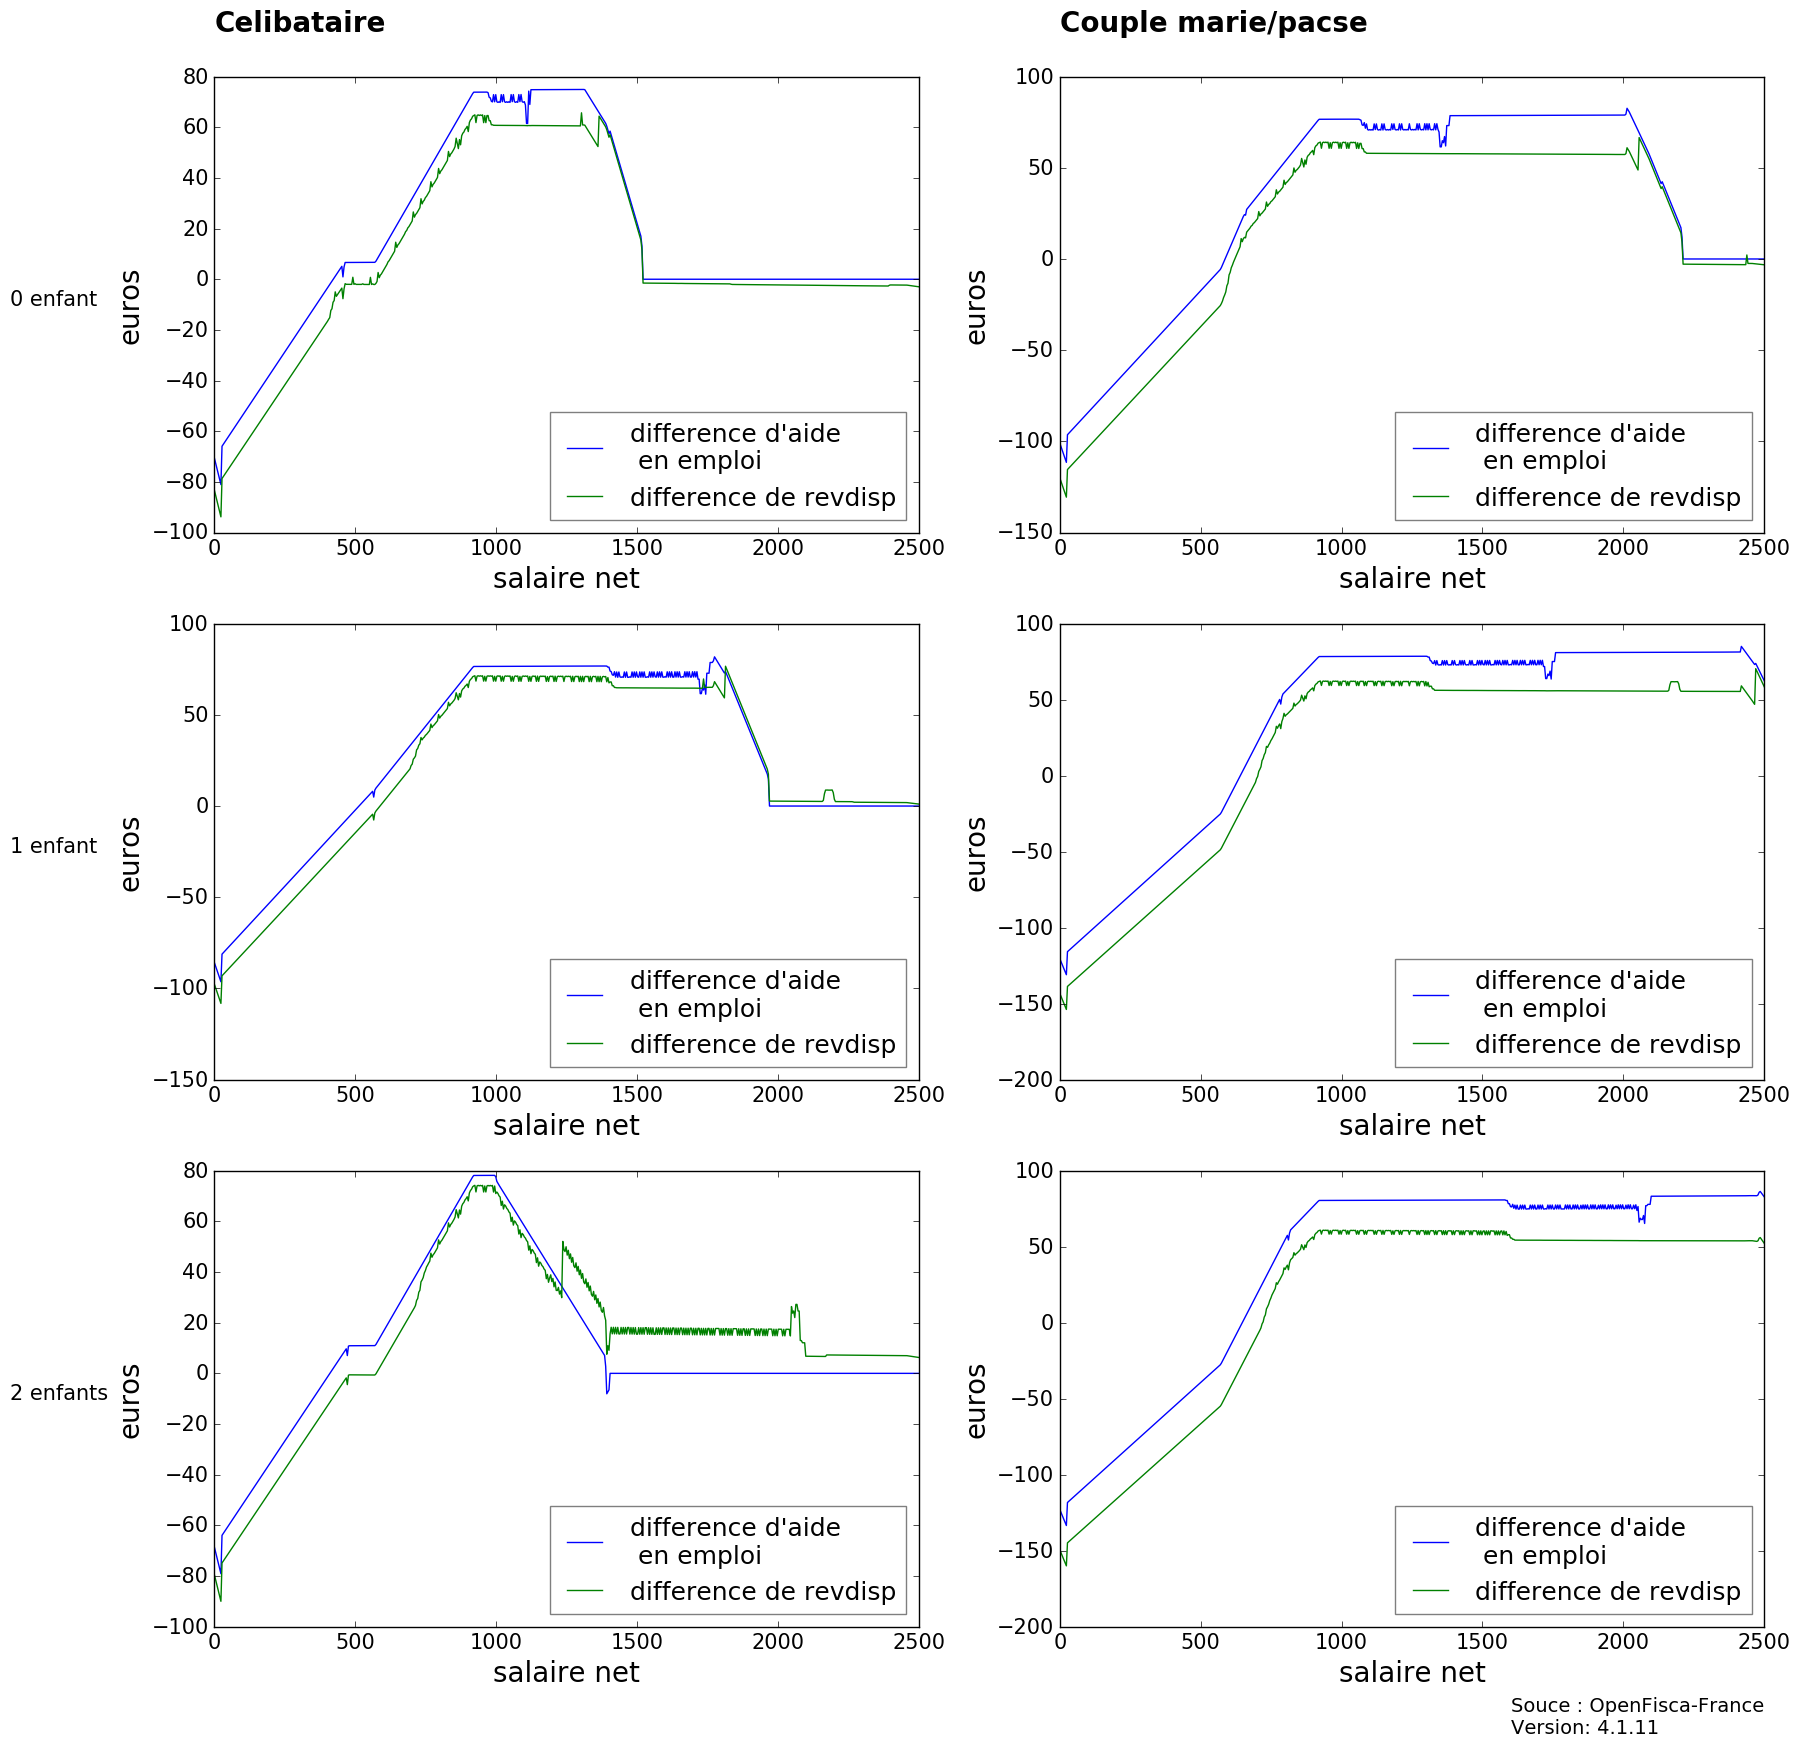

In [104]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))
fontsize = 20
for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        aide_emploi_2015 = (simulation_2015.calculate_add("ppe") + simulation_2015.calculate_add("rsa"))/12
        aide_emploi_2016 = (simulation_2016.calculate_add("ppa") + simulation_2016.calculate_add("rsa"))/12
        revdisp_2015 = simulation_2015.calculate_add("revdisp")/12
        revdisp_2016 = simulation_2016.calculate_add("revdisp")/12
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2016 - aide_emploi_2015,
            label = "difference d'aide \n en emploi"
                )
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2016 - revdisp_2015,
            label = 'difference de revdisp'
                )
        
        
        
        ax[raw,col].set_xlim(0,2500)
        #ax[raw,col].set_ylim(0,30000)
        legend = ax[raw,col].legend(loc = 4, fontsize = 18); legend.get_frame().set_alpha(0.5)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize); ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
    

            
plt.text(1600, -270, s = source, fontsize=14)

## Courbes de budget

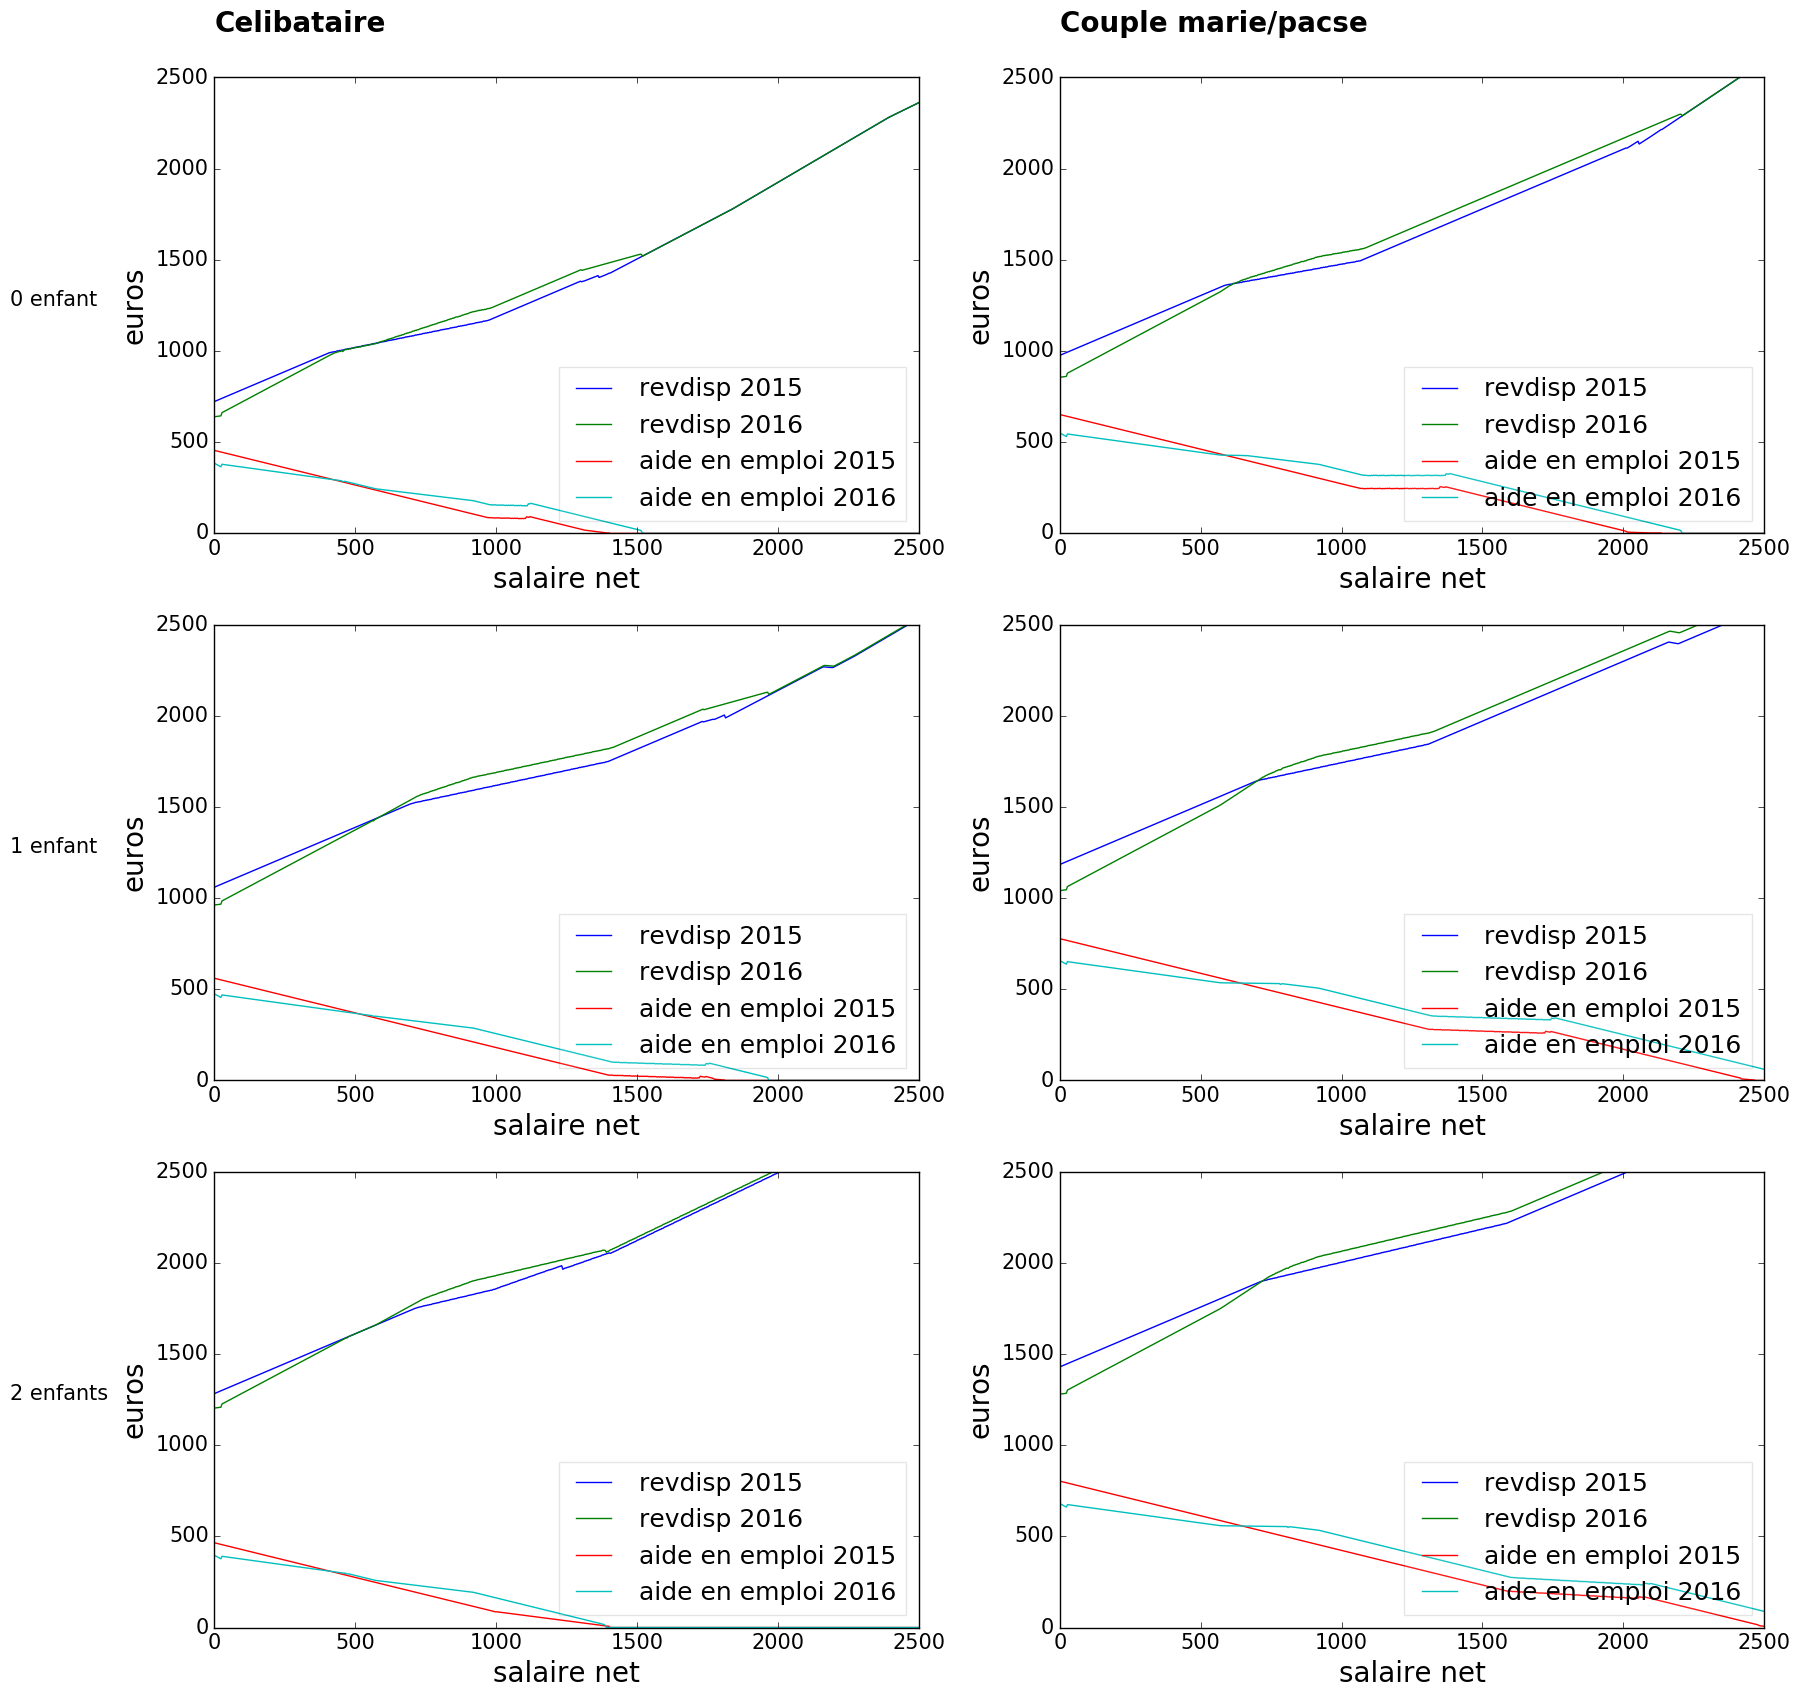

In [109]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))

for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        
        revdisp_2015 = simulation_2015.calculate_add("revdisp") 
        revdisp_2016 = simulation_2016.calculate_add("revdisp")
        
        
        aide_emploi_2015 = simulation_2015.calculate_add("ppe") + simulation_2015.calculate_add("rsa")
        aide_emploi_2016 = simulation_2016.calculate_add("ppa") + simulation_2016.calculate_add("rsa")
        
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2015/12,
            label = 'revdisp 2015'
                )
        ax[raw,col].plot(
                 simulation_2016.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2016/12,
            label = 'revdisp 2016'
                )
        ax[raw,col].plot(simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2015/12,
                         label = "aide en emploi 2015")
        ax[raw,col].plot(simulation_2016.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2016/12,
                         label = "aide en emploi 2016")

                
        ax[raw,col].set_xlim(0,2500)
        ax[raw,col].set_ylim(0,2500)
        legend = ax[raw,col].legend(loc = 4, fontsize=18); legend.get_frame().set_alpha(0.1)
        ax[raw,col].set_ylabel('euros', fontsize = fontsize) 
        ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 

### Avec taux marginaux

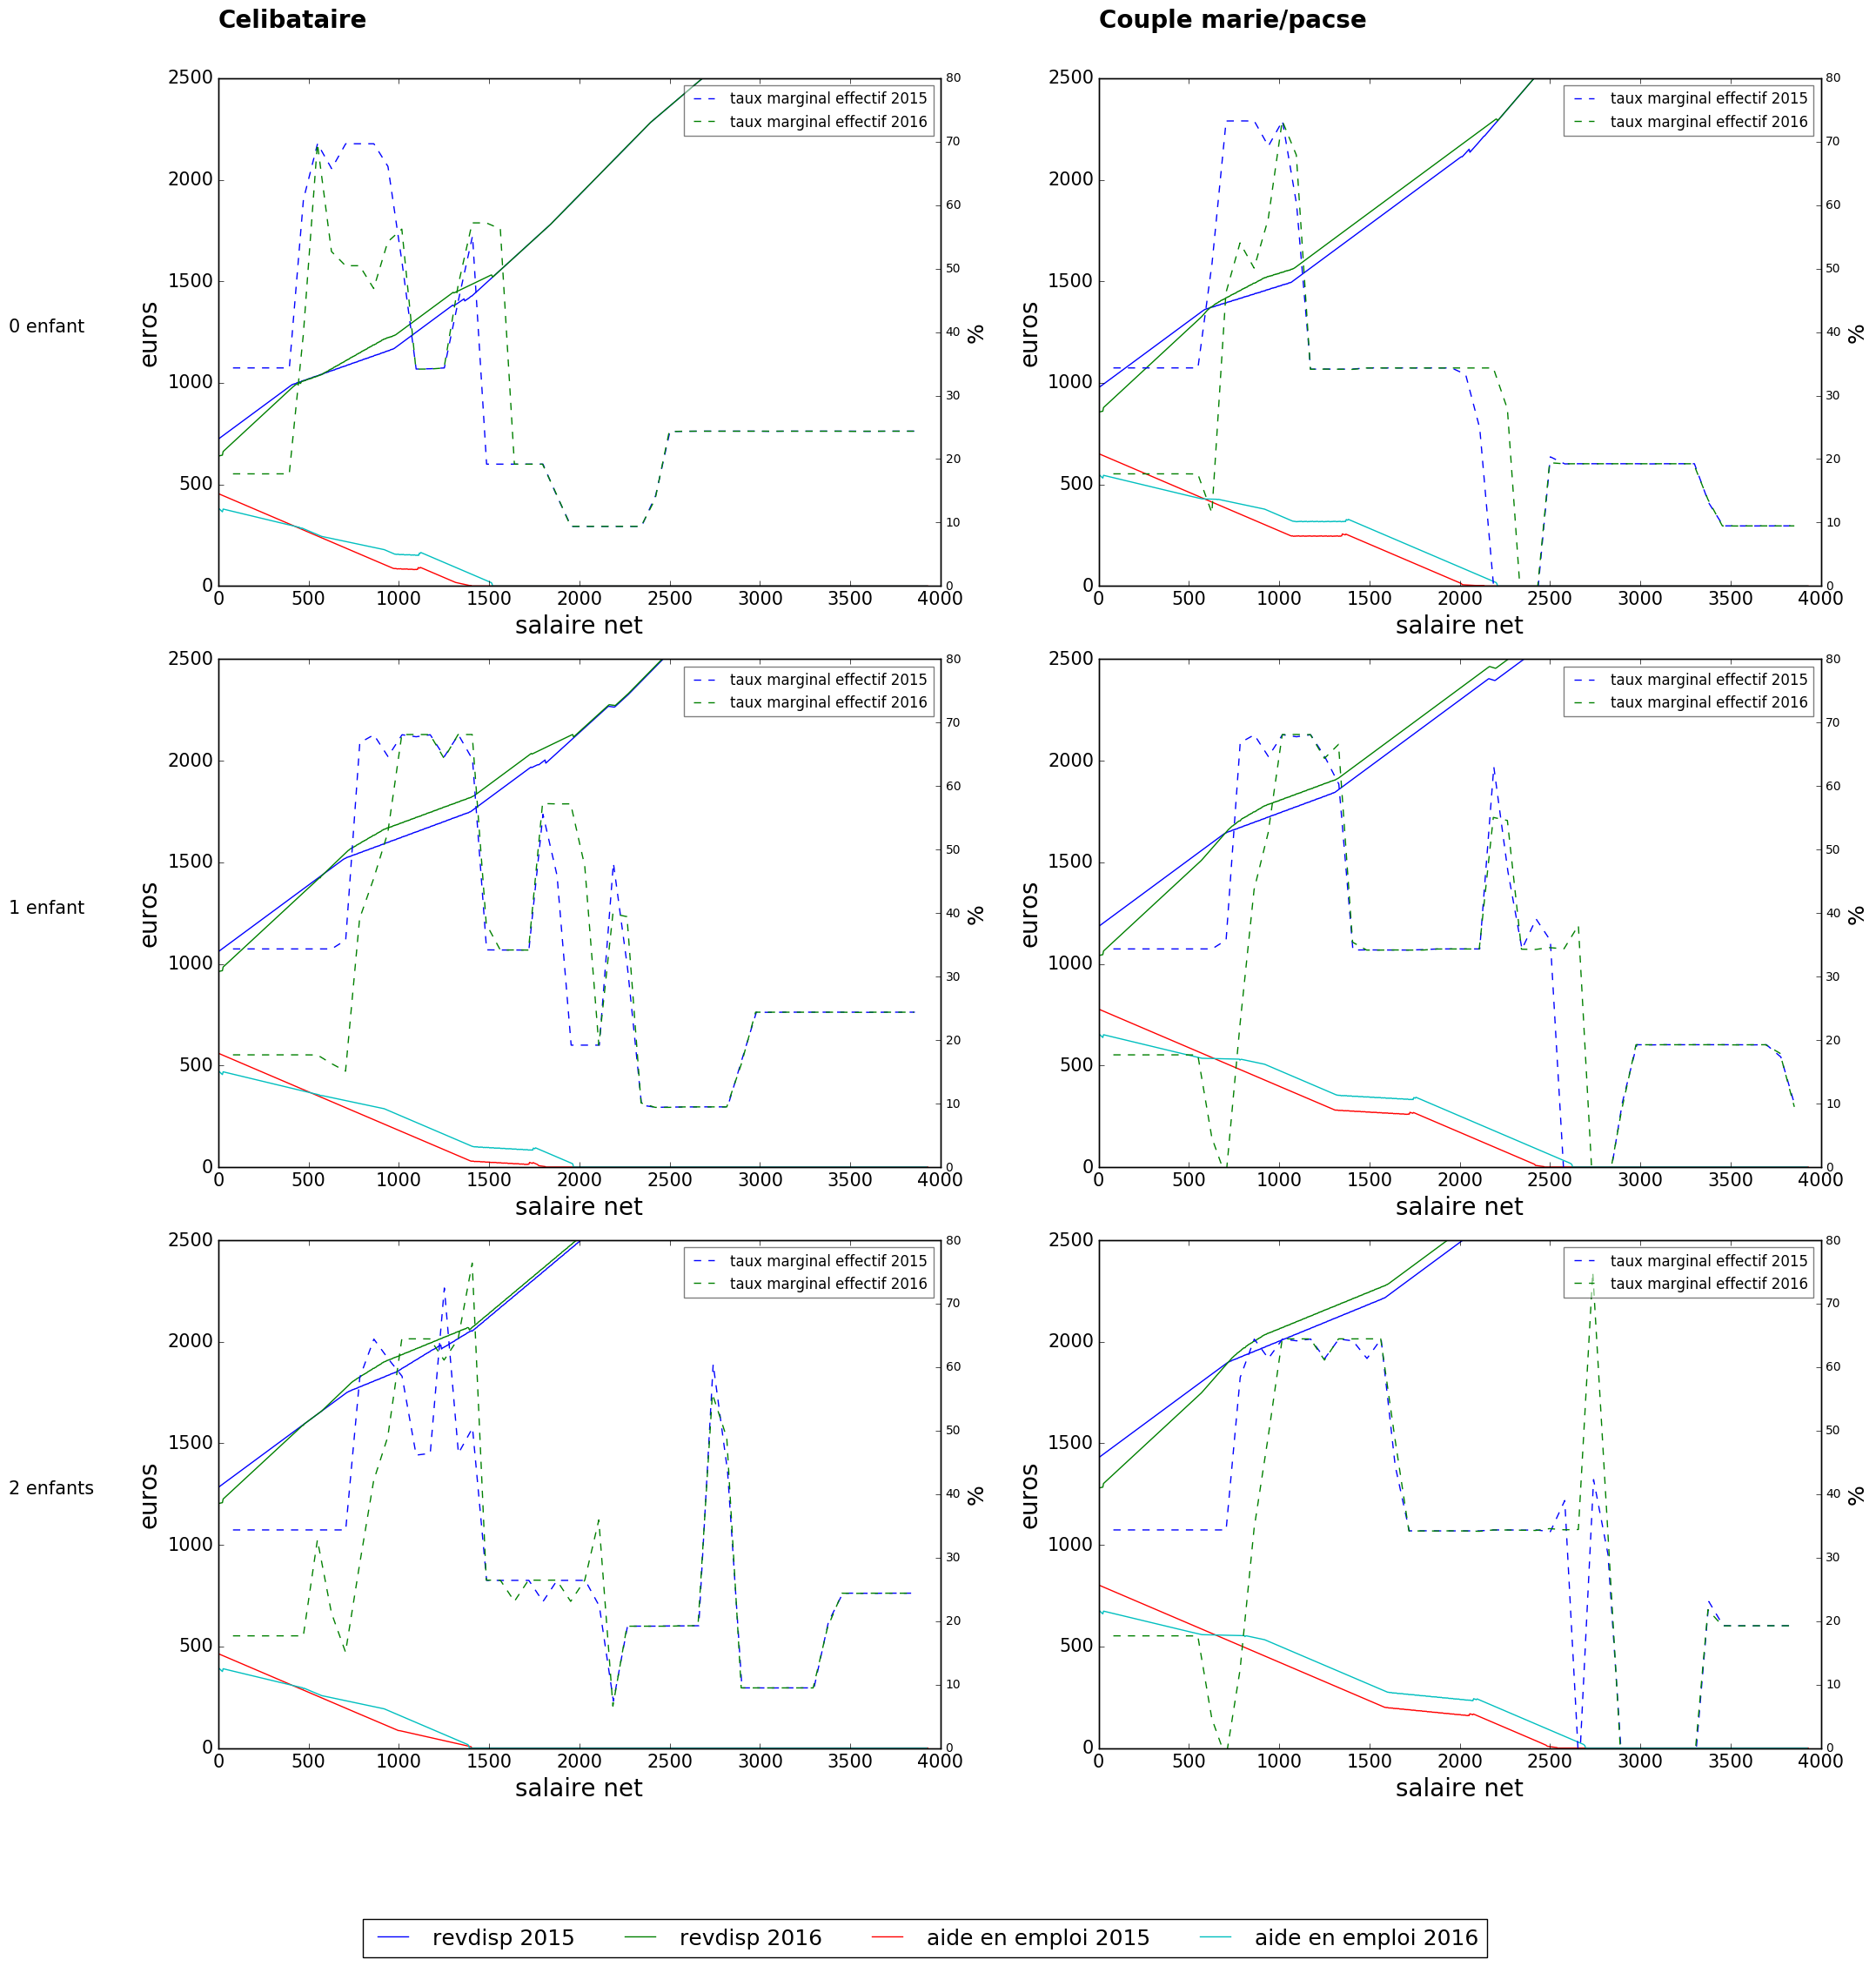

In [157]:
fig, ax = plt.subplots(3,2,figsize=(20, 20))

for col in range(2):
    for raw in range(3):
        simulation_2015 = sim_dict_2015[col][raw]
        simulation_2016 = sim_dict_2016[col][raw]
        
        revdisp_2015 = simulation_2015.calculate_add("revdisp") 
        revdisp_2016 = simulation_2016.calculate_add("revdisp")
        
        
        aide_emploi_2015 = simulation_2015.calculate_add("ppe") + simulation_2015.calculate_add("rsa")
        aide_emploi_2016 = simulation_2016.calculate_add("ppa") + simulation_2016.calculate_add("rsa")
        
        ax[raw,col].plot(
                 simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2015/12,
            label = 'revdisp 2015'
                )
        ax[raw,col].plot(
                 simulation_2016.calculate_add("salaire_net")[::raw+col+1]/12,
                 revdisp_2016/12,
            label = 'revdisp 2016'
                )
        ax[raw,col].plot(simulation_2015.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2015/12,
                         label = "aide en emploi 2015")
        ax[raw,col].plot(simulation_2016.calculate_add("salaire_net")[::raw+col+1]/12,
                 aide_emploi_2016/12,
                         label = "aide en emploi 2016")

                
        ax[raw,col].set_xlim(0,2500)
        ax[raw,col].set_ylim(0,2500)

        ax[raw,col].set_ylabel('euros', fontsize = fontsize) 
        ax[raw,col].set_xlabel('salaire net', fontsize = fontsize);
        if col == 0:
            ax[raw,col].text(-0.29, 0.5, '{} {}'.format(raw, 'enfant'*(raw<=1)+'enfants'*(raw>1)),
                             transform=ax[raw,col].transAxes, 
                size=15)
        if raw == 0:
            ax[raw,col].text(0, 1.1, '{}'.format(u"Celibataire"*(col==0)+u"Couple marie/pacse"*(col==1)),
                                                     transform=ax[raw,col].transAxes, 
                size=20, weight='bold')
            
       
    
        # Tax rate
         ## Marginal Tax rate
        ax2 = ax[raw,col].twinx()
        smooth = 20 # need to be >= 2
        ax2.plot(simulation_2015.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth]/12,
                (
                rates.marginal_rate(simulation_2015.calculate_add("revdisp")[::smooth],
                simulation_2015.calculate("salaire_net")[::raw+1+col][::smooth]
                ))*100,
                '--',
                label = "taux marginal effectif 2015",)
        ax2.plot(simulation_2016.calculate_add("salaire_net")[1+raw+col::raw+1+col][smooth::smooth]/12,
                (
                rates.marginal_rate(simulation_2016.calculate_add("revdisp")[::smooth],
                simulation_2016.calculate("salaire_net")[::raw+1+col][::smooth]
                ))*100,
                '--',
                label = "taux marginal effectif 2016",)
    

        legend = ax2.legend(loc = 1); legend.get_frame().set_alpha(0.5)
        ax2.set_ylim(0,80)
        
                
        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(150) 

        ax2.set_ylabel('%', fontsize = 18)
        legend = ax2.legend(loc = 1); legend.get_frame().set_alpha(0.5)
            
        for tick in ax[raw,col].xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
        for tick in ax[raw,col].yaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)      
legend = ax[0,0].legend(loc = (0.2,-2.7),ncol=4, fontsize=18); legend.get_frame().set_alpha(1)

In [155]:
hello = ax2.yaxis.get_major_ticks()[3]
hello.set_font